# Creating Initial and boundary conditions for MOM6 from SODA3

In [1]:
from PyCNAL_regridding import *

In [2]:
# ---------- path to MOM6 grid and SODA3 data ---------------------
momgrd = '/Users/james/Downloads/nwa_ocean_hgrid.nc'

# change this to wherever you've got SODA3
#sodadir = '/Users/raphael/STORAGE/SODA3.3.1/'
sodadir = 'soda3.3.1_5dy_ocean_reg_1993_01_04.nc'

# output directory
outputdir = './'

## 1. initial Condition

In [3]:
# pick date for initial condition
#year=1992 ; month=1 ; day=1

#cyear= str(year) ; cmonth=str(month).zfill(2) ; cday = str(day).zfill(2)
#sodaic = sodadir + cyear + '/' + 'soda3.3.1_5dy_ocean_reg_' + cyear + '_' + cmonth + '_' + cday + '.nc'
sodaic = sodadir
import xarray as xr
ds = xr.open_dataset("/Users/james/Downloads/nwa_ocean_hgrid.nc")
ds 

<xarray.Dataset>
Dimensions:   (nx: 1440, nxp: 1441, ny: 720, nyp: 721)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    y         (nyp, nxp) float32 ...
    x         (nyp, nxp) float32 ...
    tile      |S5 ...
    dy        (ny, nxp) float32 ...
    dx        (nyp, nx) float32 ...
    area      (ny, nx) float32 ...
    angle_dx  (nyp, nxp) float32 ...

In [4]:
# ---------- define a domain target on MOM grid ---------------------
Nx=int(1440)
Ny=int(720)
domain = obc_segment('domain', momgrd,istart=0,iend=Nx,jstart=0,  jend=Ny)

In [5]:
# ---------- define variables on each segment ------------------
temp_domain = obc_variable(domain,'temp',geometry='surface',obctype='radiation')
salt_domain = obc_variable(domain,'salt',geometry='surface',obctype='radiation')
ssh_domain  = obc_variable(domain,'ssh' ,geometry='line'   ,obctype='flather')
vel_domain  = obc_vectvariable(domain,'u','v',geometry='surface',obctype='radiation')

In [6]:
# ---------- interpolate T/S/U/V/SSH from SODA file -------------------
# note that since temp/salt/ssh are on all defined on T-point, we can re-use
# the same interpolator (time-saving)

interp_t2s = temp_domain.interpolate_from(sodaic,'temp',frame=0,depthname='st_ocean', \
                                          coord_names=['xt_ocean','yt_ocean'],method='bilinear')
salt_domain.interpolate_from(sodaic,'salt',frame=0,depthname='st_ocean',coord_names=['xt_ocean','yt_ocean'],\
                             method='bilinear',interpolator=interp_t2s)
ssh_domain.interpolate_from(sodaic ,'ssh' ,frame=0,coord_names=['xt_ocean','yt_ocean'],\
                            method='bilinear',interpolator=interp_t2s)

# but we can't reuse the previous interpolator because u,v are defined at U,V point, not T point
interp_u2s, interp_v2s = vel_domain.interpolate_from(sodaic,'u','v',frame=0,depthname='st_ocean',\
                                                     coord_names_u=['xu_ocean','yu_ocean'], \
                                                     coord_names_v=['xu_ocean','yu_ocean'],method='bilinear')

Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.12770295143127441
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.12480998039245605
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.0024728775024414062
Subset source grid : full dimension is  720 330  subset is  514 631 165 259
Subset source grid : full dimension is  720 330  subset is  514 631 165 259
drown
end drown 0.25338125228881836
create regridding for u
create regridding for v
regridding u
regridding v


In [7]:
# ---------- list segments and variables to be written -------
list_segments = [domain]
list_variables = [ssh_domain,temp_domain,salt_domain]
list_vectvariables = [vel_domain]

#----------- time --------------------------------------------
time = temp_domain.timesrc

# ---------- write to file -----------------------------------
write_ic_file(list_segments,list_variables,list_vectvariables,time,output=outputdir + 'initial_condition_SODA3.nc')

nx,ny,nz = 720.5 360.5 50


/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xarray/plot/plot.py:1039: UserWarning: Attempting to set identical left == right == 9.969209968386869e+36 results in singular transformations; automatically expanding.
  ax.set_xlim(x[0], x[-1])
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xarray/plot/plot.py:1040: UserWarning: Attempting to set identical bottom == top == 9.969209968386869e+36 results in singular transformations; automatically expanding.
  ax.set_ylim(y[0], y[-1])


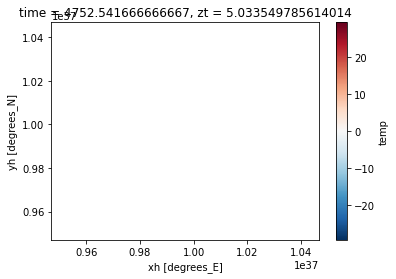

In [29]:
icnc = xr.open_dataset("initial_condition_SODA3.nc", decode_times=False)
icnc.temp[0][0].plot()

In [19]:
aicnc = xr.open_dataset("/Users/james/Downloads/soda_ic_75z_1993-01-01.nc")
aicnc.temp[0]

<xarray.Dataset>
Dimensions:  (time: 1, xh: 720, xq: 721, yh: 360, yq: 361, zl: 75)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 5.875e+03 6.125e+03 6.375e+03
Dimensions without coordinates: xh, xq, yh, yq
Data variables:
    temp     (time, zl, yh, xh) float64 ...
    salt     (time, zl, yh, xh) float64 ...
    ssh      (time, yh, xh) float64 ...
    u        (time, zl, yh, xq) float64 ...
    v        (time, zl, yq, xh) float64 ...

In [26]:
np.mean(icnc.temp[0][0].values - aicnc.temp[0][2].values)

-0.4424766619018818

In [25]:
icnc.salt[0][0].values - aicnc.salt[0][2].values

array([[ 0.58300858,  0.64761306,  0.71267137, ...,  0.00507908,
         0.00341329,  0.00238581],
       [ 0.58751727,  0.65216157,  0.71721539, ...,  0.00870781,
         0.00793486,  0.00648547],
       [ 0.59159693,  0.65625924,  0.72132967, ...,  0.01483132,
         0.0133821 ,  0.01125623],
       ...,
       [-1.03005941, -1.1330956 , -1.23186052, ..., -0.22897278,
        -0.17064277, -0.12841163],
       [-0.93674788, -1.04130383, -1.14164833, ..., -0.3346161 ,
        -0.24999237, -0.20274469],
       [-0.84761627, -0.95375781, -1.05562822, ..., -0.44324764,
        -0.3569008 , -0.28245721]])

# 2. Boundary Conditions

In [31]:
import subprocess as sp
import numpy as np

In [32]:
# pick which years to regrid
firstyear=1981 ; lastyear=1981

In [33]:

# create the list of the SODA files we want to regrid
list_soda_files = ["soda3.3.1_5dy_ocean_reg_1992_01_05.nc"]

'''
list_soda_files = []
for year in np.arange(firstyear,lastyear+1):
    cmd = 'ls ' + sodadir + '/' + str(year) + ' | grep nc '
    list_this_year = sp.check_output(cmd,shell=True).replace('\n',' ').split()
    for sodafile in list_this_year:
        list_soda_files.append(sodadir + '/' + str(year) + '/' + sodafile)
        '''

"\nlist_soda_files = []\nfor year in np.arange(firstyear,lastyear+1):\n    cmd = 'ls ' + sodadir + '/' + str(year) + ' | grep nc '\n    list_this_year = sp.check_output(cmd,shell=True).replace('\n',' ').split()\n    for sodafile in list_this_year:\n        list_soda_files.append(sodadir + '/' + str(year) + '/' + sodafile)\n        "

In [34]:

# ---------- define segments on MOM grid -----------------------
Nx=1440
Ny=720
#north = obc_segment('segment_001',momgrd,istart=Nx,iend=0, jstart=Ny,jend=Ny)
#west  = obc_segment('segment_002',momgrd,istart=0, iend=0, jstart=Ny,jend=0 )
south = obc_segment('segment_001',momgrd,istart=0, iend=Nx,jstart=0, jend=0 )
east = obc_segment('segment_002',momgrd,istart=Nx, iend=Nx,jstart=0, jend=Ny )

In [35]:
# ---------- define variables on each segment ------------------
temp_south = obc_variable(south,'temp',geometry='surface',obctype='radiation',use_locstream=True)
temp_east  = obc_variable(east, 'temp',geometry='surface',obctype='radiation',use_locstream=True)

salt_south = obc_variable(south,'salt',geometry='surface',obctype='radiation',use_locstream=True)
salt_east  = obc_variable(east, 'salt',geometry='surface',obctype='radiation',use_locstream=True)

zeta_south = obc_variable(south,'zeta',geometry='line',obctype='flather',use_locstream=True)
zeta_east  = obc_variable(east ,'zeta',geometry='line',obctype='flather',use_locstream=True)

vel_south  = obc_vectvariable(south,'u','v',geometry='surface',obctype='radiation',use_locstream=True)
vel_east   = obc_vectvariable(east ,'u','v',geometry='surface',obctype='radiation',use_locstream=True)

In [36]:
# ---------- run the regridding on the list of files ------------------
# for the first call to the regridding, we save all the interpolators
# (for each segment, and each type of variable), so we don't need to
# recompute the regridding weights for the N-1 following files

first_call=True

for sodafile in list_soda_files:
    print('working on ' + sodafile)
    filein=sodafile.replace('/',' ').split()[-1]
    fileout= outputdir + filein.replace('.nc','_obc.nc')

    if first_call:
        interp_t2s_south = temp_south.interpolate_from(sodafile,'temp',frame=0,depthname='st_ocean',\
                                                       coord_names=['xt_ocean','yt_ocean'])
        interp_t2s_east  = temp_east.interpolate_from(sodafile ,'temp',frame=0,depthname='st_ocean',\
                                                      coord_names=['xt_ocean','yt_ocean'])
    else:
        temp_south.interpolate_from(sodafile,'temp',frame=0,depthname='st_ocean',\
                                    coord_names=['xt_ocean','yt_ocean'],interpolator=interp_t2s_south)
        temp_east.interpolate_from(sodafile ,'temp',frame=0,depthname='st_ocean',\
                                   coord_names=['xt_ocean','yt_ocean'],interpolator=interp_t2s_east)

    salt_south.interpolate_from(sodafile,'salt',frame=0,depthname='st_ocean',\
                                coord_names=['xt_ocean','yt_ocean'],interpolator=interp_t2s_south)
    salt_east.interpolate_from(sodafile ,'salt',frame=0,depthname='st_ocean',\
                               coord_names=['xt_ocean','yt_ocean'],interpolator=interp_t2s_east)

    zeta_south.interpolate_from(sodafile,'ssh',frame=0,depthname='st_ocean',\
                                coord_names=['xt_ocean','yt_ocean'],interpolator=interp_t2s_south)
    zeta_east.interpolate_from(sodafile ,'ssh',frame=0,depthname='st_ocean',\
                               coord_names=['xt_ocean','yt_ocean'],interpolator=interp_t2s_east)

    if first_call:
        interp_u2s_south, interp_v2s_south = vel_south.interpolate_from(sodafile,'u','v',frame=0,depthname='st_ocean',\
        coord_names_u=['xu_ocean','yu_ocean'],coord_names_v=['xu_ocean','yu_ocean'])

        interp_u2s_east, interp_v2s_east = vel_east.interpolate_from(sodafile ,'u','v',frame=0,depthname='st_ocean',\
        coord_names_u=['xu_ocean','yu_ocean'],coord_names_v=['xu_ocean','yu_ocean'])
    else:
        vel_south.interpolate_from(sodafile,'u','v',frame=0,depthname='st_ocean',\
        coord_names_u=['xu_ocean','yu_ocean'],coord_names_v=['xu_ocean','yu_ocean'],\
        interpolator_u=interp_u2s_south,interpolator_v=interp_v2s_south)

        vel_east.interpolate_from(sodafile ,'u','v',frame=0,depthname='st_ocean',\
        coord_names_u=['xu_ocean','yu_ocean'],coord_names_v=['xu_ocean','yu_ocean'],\
        interpolator_u=interp_u2s_east,interpolator_v=interp_v2s_east)
        
    # ---------- list segments and variables to be written -------
    list_segments = [south,east]

    list_variables = [temp_south,temp_east, \
                      salt_south,salt_east, \
                      zeta_south,zeta_east ]

    list_vectvariables = [vel_south,vel_east]

    #----------- time --------------------------------------------
    time = temp_south.timesrc

    # ---------- write to file -----------------------------------
    write_obc_file(list_segments,list_variables,list_vectvariables,time,output=fileout)

    first_call=False

working on soda3.3.1_5dy_ocean_reg_1992_01_05.nc
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.1357429027557373
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.14094114303588867
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.14329195022583008
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.14303898811340332
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.0026051998138427734
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.0025703907012939453
Subset source grid : full dimension is  720 330  subset is  514 631 165 259
Subset source grid : full dimension is  720 330  subset is  514 631 165 259
drown
end drown 0.2848551273345947
create regridding for u
create regridding for v
regridding u
regridding v
Subset source g

In [52]:
ic = xr.open_dataset("initial_condition_SODA3.nc", decode_times=False)
ic

<xarray.Dataset>
Dimensions:     (interfaces: 51, time: 1, xh: 720, xq: 721, yh: 360, yq: 361, zt: 50, zw: 51)
Coordinates:
  * time        (time) float64 4.388e+03
  * zt          (zt) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03
  * zw          (zw) float64 0.0 10.07 20.19 30.32 ... 5.18e+03 5.39e+03 5.6e+03
  * yh          (yh) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * xh          (xh) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * yq          (yq) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * xq          (xq) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * interfaces  (interfaces) float64 0.0 10.07 20.19 ... 5.39e+03 5.6e+03
Data variables:
    ssh         (time, yh, xh) float64 ...
    temp        (time, zt, yh, xh) float64 ...
    salt        (time, zt, yh, xh) float64 ...
    u           (time, zt, yh, xq) float64 ...
    v           (time, zt, yq, xh) float64 ...

In [65]:
ic.salt[0][20].values

array([[34.72673181, 34.72358191, 34.7206997 , ..., 36.47821363,
        36.4824325 , 36.47965793],
       [34.72694936, 34.72379534, 34.72091167, ..., 36.46613733,
        36.46154594, 36.45619439],
       [34.72689945, 34.72374226, 34.72085565, ..., 36.44495281,
        36.43959948, 36.43348608],
       ...,
       [35.0138568 , 35.02586526, 35.03774777, ..., 34.1016942 ,
        34.09283618, 34.08445236],
       [35.01051432, 35.02256768, 35.03449941, ..., 34.09277662,
        34.08373014, 34.07543526],
       [35.00729266, 35.01939522, 35.03137204, ..., 34.08363243,
        34.07471701, 34.06622457]])

In [55]:
Ny

360